In [125]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

from scipy.stats import loguniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# import dataset (which we created in Task 1)
# dfPhiladelphiaIncluding0TripsUniqueHours = pd.read_csv("data/exports/dfPhiladelphiaIncluding0TripsUniqueHours.csv.zip")
# dfPhiladelphiaIncluding0TripsUniqueHours.info()

In [126]:
# read in dataset
charging_set_complete = pd.read_csv("data/cleaned_charging_set_new.csv")

In [127]:
# read in dataset
weather_set = pd.read_csv("data/cleaned_weather_set.csv")

In [128]:
# seperate data into site 1 and site 2
charging_set_site1 = charging_set_complete[charging_set_complete["siteID"] == 1]
charging_set_site2 = charging_set_complete[charging_set_complete["siteID"] == 2]

In [129]:
# Create a copy of the DataFrame to avoid the warning
charging_set_site1 = charging_set_site1.copy()

# Convert to datetime
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])

# Sort ascending
charging_set_site1 = charging_set_site1.sort_values(by="connectionTime").reset_index(drop=True)

# Set min and max time
min_time = charging_set_site1["connectionTime"].min().floor("h")
max_time = charging_set_site1["disconnectTime"].max().ceil("h")

# Create DataFrame for every hour
hours_df = pd.DataFrame({"hour": pd.date_range(start=min_time, end=max_time, freq="h")})
hours_df.head()


,hour
0,2018-09-05 11:00:00+00:00
1,2018-09-05 12:00:00+00:00
2,2018-09-05 13:00:00+00:00
3,2018-09-05 14:00:00+00:00
4,2018-09-05 15:00:00+00:00


In [130]:
# Combine date and time columns into single datetime columns
charging_set_site2 = charging_set_site2.copy()

charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])
# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)
# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('h')
max_time = charging_set_site2['disconnectTime'].max().ceil('h')
# create df
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='h')})
hours_df2.head()


,hour
0,2018-04-25 11:00:00+00:00
1,2018-04-25 12:00:00+00:00
2,2018-04-25 13:00:00+00:00
3,2018-04-25 14:00:00+00:00
4,2018-04-25 15:00:00+00:00


Now we want to create our target variables that we want to predict later. For this we create 2 values:
- connectedCars: the number of active charging sessions for each other
    - utilization: the actual number of minutes that was charged for each hour

The utiliaztion column effectivly sums up the active charging minutes for each hour and divides that by the maximum number of minutes that could be charged. In case of sitze 1 for example that would mean 60x52 = 3120 are the max charging miinutes for this site per hour. If we divide the minutes of active sessions by this value, we get the precise percentage of the charging site utilization.

# CALCULATION FOR SITE 1

In [131]:


# Number of spaces (total available spaces site 1)
total_spaces = 52

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)

    # Filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
        ]

    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes

    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[0]
)

# Compute connectedCars column
hours_df['connectedCars'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[1]
)

# Display results
hours_df.head()


,hour,utilization,connectedCars
0,2018-09-05 11:00:00+00:00,0.034498,2
1,2018-09-05 12:00:00+00:00,0.049119,4
2,2018-09-05 13:00:00+00:00,0.139071,10
3,2018-09-05 14:00:00+00:00,0.260994,15
4,2018-09-05 15:00:00+00:00,0.269231,14


# CALCULATION FOR SITE 2

In [132]:
# Number of spaces (total available spaces site 1)
total_spaces = 54

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)

    # Filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
        ]

    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes

    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[0]
)

# Compute connectedCars column
hours_df2['connectedCars'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[1]
)

# Display results
hours_df2.head()


,hour,utilization,connectedCars
0,2018-04-25 11:00:00+00:00,0.016029,1
1,2018-04-25 12:00:00+00:00,0.018519,1
2,2018-04-25 13:00:00+00:00,0.015175,3
3,2018-04-25 14:00:00+00:00,0.059378,7
4,2018-04-25 15:00:00+00:00,0.253596,22


# MERGE TARGET VARIABLE AND WEATHER DATASET

In [133]:
# transform column to the same format
hours_df["hour"] = hours_df["hour"].dt.tz_localize(None)
hours_df2["hour"] = hours_df2["hour"].dt.tz_localize(None)

# Convert the "timestamp" column in the weather data to datetime
weather_set["timestamp"] = pd.to_datetime(weather_set["timestamp"])

# Round the weather data timestamps to the nearest hour
weather_set["timestamp"] = weather_set["timestamp"].dt.floor("h")

# Merge the datasets based on the "timestamp" column
merged_data_site1 = pd.merge(hours_df, weather_set, left_on="hour", right_on="timestamp", how="left")
merged_data_site2 = pd.merge(hours_df2, weather_set, left_on="hour", right_on="timestamp", how="left")
# Drop the redundant "timestamp" column from the weather data after merging
merged_data_site1 = merged_data_site1.drop(columns=["timestamp"])
merged_data_site2 = merged_data_site2.drop(columns=["timestamp"])

In [134]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
    ]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
    ]
print(len(filtered_data),len(filtered_data2))

2300 2300


In [135]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

# FEATURE ENGINEERING

CREATE NEW FEATURES FOR SITE 1

In [136]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# Add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# Resulting DataFrame
merged_data_site1.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,1,11
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,12
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,13
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,13
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3.0,0,2,14


In [137]:
# drop NaN values
merged_data_site1 = merged_data_site1.dropna()
merged_data_site2 = merged_data_site2.dropna()

In [138]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
    ]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
    ]
# print(len(filtered_data),len(filtered_data2))

In [139]:
zero_connected_cars_count = filtered_data[filtered_data['connectedCars'] == 0].shape[0]
zero_connected_cars_count2 = filtered_data2[filtered_data2['connectedCars'] == 0].shape[0]
print(zero_connected_cars_count,zero_connected_cars_count2)

0 0


## REMOVE DATA GAP FROM AUGUST 2020 UNTIL OKTOBER 2020

In [140]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

# CREATE NEW FEATURES FOR SITE 1

In [141]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# Add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# Resulting DataFrame
merged_data_site1.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,1,11
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,12
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,14


# CREATE NEW FEATURES FOR SITE 2

In [142]:
# create season column and weekend/weekday column and covvid column
merged_data_site2["hour"] = pd.to_datetime(merged_data_site2["hour"])
# Add covid column
merged_data_site2["covid"] = merged_data_site2["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site2["weekday"] = merged_data_site2["hour"].apply(lambda x: x.weekday())

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site2["Season"] = merged_data_site2["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site2["Weekday/Weekend"] = merged_data_site2["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site2["Season"] = merged_data_site2["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site2["time_of_day"] = merged_data_site2["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site2["hour_of_day"] = merged_data_site2["hour"].dt.hour
# Resulting DataFrame
merged_data_site2.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,1,11
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13


## REMOVE CITY & CLOUD_COVER_DESCRIPTION FROM DATASET

In [143]:
print("merged data site 1:", merged_data_site1.columns)
print("merged data site 2:", merged_data_site2.columns)

merged data site 1: Index(['hour', 'utilization', 'connectedCars', 'city', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation', 'felt_temperature', 'temperature_difference',
       'date_year', 'date_month', 'date_day', 'time', 'mostly', 'heavy', 'fog',
       'windy', 'blowing_dust', 'fair', 'haze', 'partly', 'rain',
       'light_rain_thunder', 'light', 't-storm', 'thunder',
       'thunder_in_vicinity', 'cloudy', 'smoke', 'covid', 'weekday', 'Season',
       'Weekday/Weekend', 'time_of_day', 'hour_of_day'],
      dtype='object')
merged data site 2: Index(['hour', 'utilization', 'connectedCars', 'city', 'temperature',
       'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed',
       'precipitation', 'felt_temperature', 'temperature_difference',
       'date_year', 'date_month', 'date_day', 'time', 'mostly', 'heavy', 'fog',
       'windy', 'blowing_dust', 'fair', 'haze', 'partly', 'rain',
       'light_rain_thu

In [144]:
merged_data_site1.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)
merged_data_site2.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)

# FEATURE SELECTION FOR SITE 1

In [145]:

# Compute correlation matrix
correlation_matrix = merged_data_site1.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)


Correlation with connectedCars:
connectedCars             1.000000
utilization               0.990622
hour_of_day               0.437645
time_of_day               0.382096
felt_temperature          0.227559
temperature               0.226119
windspeed                 0.148586
haze                      0.067633
temperature_difference    0.036858
precipitation             0.032606
t-storm                   0.032275
cloud_cover               0.026339
partly                    0.025046
heavy                     0.022425
thunder                   0.017620
rain                      0.012352
pressure                  0.010597
windy                     0.010358
light                     0.008150
Season                    0.006217
fair                     -0.000765
mostly                   -0.005502
fog                      -0.008564
date_day                 -0.016239
cloudy                   -0.023917
smoke                    -0.026620
date_month               -0.040711
date_year              

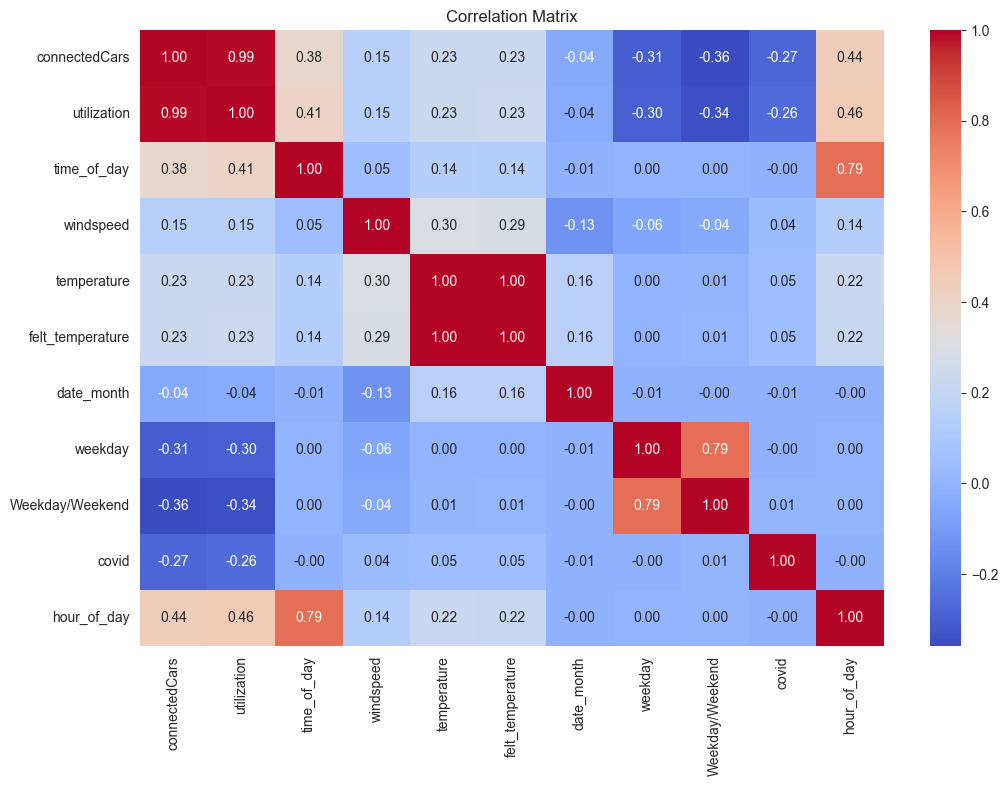

In [146]:
# compute correlation and display correlation for newly selected features
predictionDF_site1 = merged_data_site1[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site1.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# FEATURE SELECTION SITE 2

In [147]:

# Compute correlation matrix
correlation_matrix = merged_data_site2.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

Correlation with connectedCars:
connectedCars             1.000000
utilization               0.988808
felt_temperature          0.406886
temperature               0.403437
hour_of_day               0.310937
time_of_day               0.240828
windspeed                 0.233049
Season                    0.140222
temperature_difference    0.118462
cloud_cover               0.086688
fair                      0.055569
partly                    0.033636
haze                      0.031960
date_month                0.031942
thunder                   0.022552
t-storm                   0.016446
smoke                     0.001943
windy                    -0.001683
date_day                 -0.004771
heavy                    -0.007930
precipitation            -0.009303
light                    -0.025933
mostly                   -0.028087
rain                     -0.033953
fog                      -0.036501
cloudy                   -0.047277
pressure                 -0.100740
weekday                

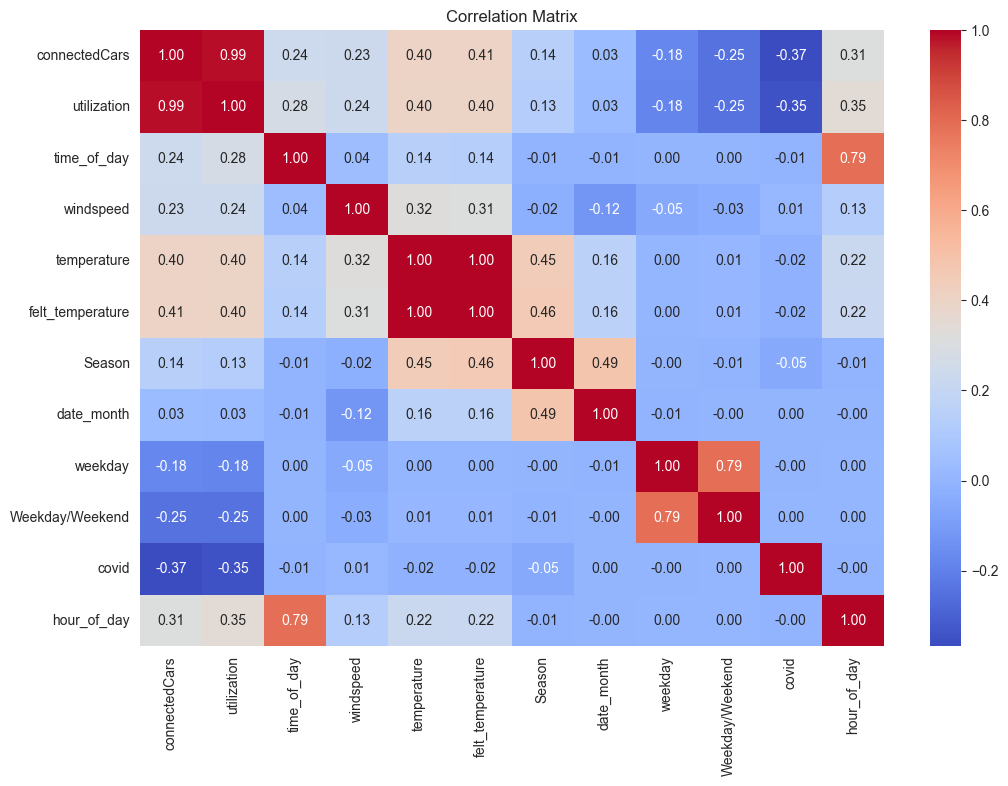

In [148]:
# compute correlation and display correlation for newly selected features
predictionDF_site2 = merged_data_site2[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","Season","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site2.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# ------------------------------------------------------------------------------------


# ---------------------------------HOT STUFF---------------------------------

# ------------------------------------------------------------------------------------

## NEURAL NETWORK: PREDICTION connectedCars SITE 1

In [149]:
X_s1 = predictionDF_site1.copy()
X_s1 = X_s1.drop(["connectedCars","utilization","temperature","time_of_day"], axis = 1)
y_s1 = predictionDF_site1[["connectedCars"]]

In [150]:
X_s1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20351 entries, 0 to 22813
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         20351 non-null  float64
 1   felt_temperature  20351 non-null  float64
 2   date_month        20351 non-null  float64
 3   weekday           20351 non-null  int64  
 4   Weekday/Weekend   20351 non-null  int64  
 5   covid             20351 non-null  int64  
 6   hour_of_day       20351 non-null  int32  
dtypes: float64(3), int32(1), int64(3)
memory usage: 1.2 MB


In [151]:
# Split data into train and test sets
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_s1, y_s1, test_size=0.3, random_state=42)
X_s1_train, X_s1_val, y_s1_train, y_s1_val = train_test_split(X_s1_train, y_s1_train, test_size=(0.2/0.7),random_state = 42)

                                                  # Standardize the feature values
scaler = StandardScaler()
X_s1_train = scaler.fit_transform(X_s1_train)
X_s1_val = scaler.fit_transform(X_s1_val)
X_s1_test = scaler.transform(X_s1_test)

In [152]:
def build_model_nn_s1(hp):
    # Input Layer
    inputs = keras.Input(shape=(7,)) # shapesize dependent of input feature count

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)

    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)

    # Output Layer
    output = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='connectedCars_NN_site1')

    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

# HYPERPARAMETER TUNING SITE 1

In [153]:
tuner_nn_s1 = Hyperband(
    build_model_nn_s1,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

In [154]:
# display search space
tuner_nn_s1.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


In [155]:
# define callback to clear training outputs at end of every training step
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# RUN HYPERPARAMETER SEARCH

In [156]:
tuner_nn_s1.search(
    X_s1_train,
    y_s1_train,
    validation_data=(X_s1_val,y_s1_val),
    callbacks = [ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 34s]
val_loss: 505.4062805175781

Best val_loss So Far: 50.122596740722656
Total elapsed time: 00h 07m 40s


In [157]:
# display best models, their hyperparameters and the resulting metrics
tuner_nn_s1.results_summary()

Results summary
Results in ./kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0028 summary
Hyperparameters:
hidden_layer_1_units: 128
total_added_hidden_layers: 10
hidden_layers_2_units: 160
hidden_layers_3_units: 64
hidden_layers_4_units: 160
hidden_layers_5_units: 128
hidden_layers_6_units: 192
hidden_layers_7_units: 32
hidden_layers_8_units: 224
hidden_layers_9_units: 224
hidden_layers_10_units: 224
hidden_layers_11_units: 160
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 50.122596740722656

Trial 0025 summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 7
hidden_layers_2_units: 160
hidden_layers_3_units: 192
hidden_layers_4_units: 96
hidden_layers_5_units: 96
hidden_layers_6_units: 64
hidden_layers_7_units: 128
hidden_layers_8_units: 224
hidden_layers_9_units: 64
hidden_layers_10_units: 256
hidden_layers_11_units: 192
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round

In [158]:
nn_best_hps_site1 = tuner_nn_s1.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {nn_best_hps_site1.get('hidden_layer_1_units')} 
and the total number of hidden layers is {nn_best_hps_site1.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 128 
and the total number of hidden layers is 11.


In [159]:
# get best model
nn_model_site1 = tuner_nn_s1.get_best_models(num_models=1)[0]

/Users/anthonyge/Desktop/UNI/_MASTER/semester_1/Analytics_&_Applications/GinyuForce/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [160]:
nn_model_site1.summary()

Model: "connectedCars_NN_site1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        20,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 224)            │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 160)            │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,273 (930.75 KB)

 Trainable params: 238,273 (930.75 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True
)

In [162]:
nn_model_site1.fit(X_s1_train, y_s1_train, epochs=1000, validation_data=(X_s1_val,y_s1_val), callbacks=[callback])


Epoch 1/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 52.9400 - val_loss: 51.1731
Epoch 2/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 53.1205 - val_loss: 56.3690
Epoch 3/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 46.0426 - val_loss: 53.8670
Epoch 4/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 45.4296 - val_loss: 61.6413
Epoch 5/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 48.0027 - val_loss: 49.8183
Epoch 6/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 41.8387 - val_loss: 50.4425
Epoch 7/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 44.0092 - val_loss: 49.7677
Epoch 8/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 43.8535 - val_loss: 51.4635
Epoch 9/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 46.1974 - val_loss: 56.6471
Epoch 10/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 45.2301 - val_loss: 55.5446
Epoch 11/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.2265 - val_loss: 52.2192
Epoch 12

In [163]:
nn_pred_site1 = nn_model_site1.predict(X_s1_test)

# Calculate MAE, RMSE and r2
nn_mae_s1 = mean_absolute_error(y_s1_test,nn_pred_site1)
nn_rmse_s1 = mean_squared_error(y_s1_test,nn_pred_site1)**0.5
nn_r2_s1 = r2_score(y_s1_test, nn_pred_site1)

print("MAE:", nn_mae_s1)
print("RMSE:", nn_rmse_s1)
print("R2:", nn_r2_s1)
print("Accuracy:", round((1-(nn_mae_s1/predictionDF_site1["connectedCars"].mean()))*100,2), "%")


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 3.2738418579101562
RMSE: 7.171414628555388
R2: 0.8550764918327332
Accuracy: 72.74 %


# NEURAL NETWORK: PREDICTION connectedCars SITE 2

In [164]:
X_s2 = predictionDF_site2.copy()
X_s2 = X_s2.drop(["connectedCars","utilization","temperature","time_of_day"], axis = 1)
y_s2 = predictionDF_site2[["connectedCars"]]

In [165]:
X_s2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23792 entries, 0 to 26295
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         23792 non-null  float64
 1   felt_temperature  23792 non-null  float64
 2   Season            23792 non-null  int64  
 3   date_month        23792 non-null  float64
 4   weekday           23792 non-null  int64  
 5   Weekday/Weekend   23792 non-null  int64  
 6   covid             23792 non-null  int64  
 7   hour_of_day       23792 non-null  int32  
dtypes: float64(3), int32(1), int64(4)
memory usage: 1.5 MB


In [166]:
X_s2.head()

,windspeed,felt_temperature,Season,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,6.0,12.0,1,4.0,2,0,0,11
1,7.0,12.0,1,4.0,2,0,0,12
2,9.0,12.0,1,4.0,2,0,0,12
3,9.0,12.0,1,4.0,2,0,0,13
4,7.0,12.0,1,4.0,2,0,0,13


In [167]:
X_s1.head()

,windspeed,felt_temperature,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,6.0,19.0,9.0,2,0,0,11
1,6.0,19.0,9.0,2,0,0,12
2,7.0,19.0,9.0,2,0,0,13
3,7.0,19.0,9.0,2,0,0,13
4,0.0,19.0,9.0,2,0,0,14


In [168]:
# Split data into train and test sets
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(X_s2, y_s2, test_size=0.3, random_state=42)
X_s2_train, X_s2_val, y_s2_train, y_s2_val = train_test_split(X_s2_train, y_s2_train, test_size=(0.2/0.7),random_state = 42)

# Standardize the feature values
scaler = StandardScaler()
X_s2_train = scaler.fit_transform(X_s2_train)
X_s2_val = scaler.fit_transform(X_s2_val)
X_s2_test = scaler.transform(X_s2_test)

In [169]:
def build_model_nn_s2(hp):
    # Input Layer
    # season is in here, but not in site 1 df
    inputs = keras.Input(shape=(8,)) # shapesize dependent of input feature count

    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)

    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)

    # Output Layer
    output = layers.Dense(1, activation='relu')(x)

    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='connectedCars_NN_site1')

    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

# HYPERPARAMETER TUNING SITE 2

In [170]:
tuner_nn_s2 = Hyperband(
    build_model_nn_s2,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG_nn_site2',
    overwrite = True # deletes old LOG's
)

In [171]:
# tuner_nn_s2.search_space_summary()

# RUN HYPERPARAMETER SEARCH SITE 2

In [172]:
tuner_nn_s2.search(
    X_s2_train,
    y_s2_train,
    validation_data=(X_s2_val,y_s2_val),
    callbacks = [ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 29s]
val_loss: 31.39129066467285

Best val_loss So Far: 28.865205764770508
Total elapsed time: 00h 07m 21s


In [173]:
# display best models, their hyperparameters and the resulting metrics
tuner_nn_s2.results_summary()

Results summary
Results in ./kerastuner_LOG_nn_site2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
hidden_layer_1_units: 192
total_added_hidden_layers: 4
hidden_layers_2_units: 64
hidden_layers_3_units: 256
hidden_layers_4_units: 224
hidden_layers_5_units: 96
hidden_layers_6_units: 96
hidden_layers_7_units: 32
hidden_layers_8_units: 96
hidden_layers_9_units: 256
hidden_layers_10_units: 64
hidden_layers_11_units: 224
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 28.865205764770508

Trial 0027 summary
Hyperparameters:
hidden_layer_1_units: 160
total_added_hidden_layers: 4
hidden_layers_2_units: 256
hidden_layers_3_units: 32
hidden_layers_4_units: 192
hidden_layers_5_units: 32
hidden_layers_6_units: 160
hidden_layers_7_units: 224
hidden_layers_8_units: 128
hidden_layers_9_units: 96
hidden_layers_10_units: 224
hidden_layers_11_units: 256
tuner/epochs: 20
tuner/initial_epoch: 0
tu

In [174]:
nn_best_hps_site2 = tuner_nn_s2.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {nn_best_hps_site2.get('hidden_layer_1_units')} 
and the total number of hidden layers is {nn_best_hps_site2.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 192 
and the total number of hidden layers is 5.


In [175]:
# get best model
nn_model_site2 = tuner_nn_s2.get_best_models(num_models=1)[0]

/Users/anthonyge/Desktop/UNI/_MASTER/semester_1/Analytics_&_Applications/GinyuForce/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [176]:
nn_model_site2.summary()

Model: "connectedCars_NN_site1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 224)            │        57,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,985 (429.63 KB)

 Trainable params: 109,985 (429.63 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True
)

In [178]:
nn_model_site2.fit(X_s2_train, y_s2_train, epochs=1000, validation_data=(X_s2_val,y_s2_val), callbacks=[callback])

Epoch 1/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 25.4136 - val_loss: 30.7327
Epoch 2/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 24.4360 - val_loss: 28.9902
Epoch 3/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.5448 - val_loss: 28.7975
Epoch 4/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.4154 - val_loss: 28.7418
Epoch 5/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.6498 - val_loss: 31.0180
Epoch 6/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 24.7862 - val_loss: 28.9821
Epoch 7/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.8296 - val_loss: 29.7181
Epoch 8/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.4073 - val_loss: 31.0251
Epoch 9/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.1887 - val_loss: 28.6006
Epoch 10/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.1855 - val_loss: 30.8960
Epoch 11/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.8330 - val_loss: 28.7391
Epoch 12

In [179]:
nn_pred_site2 = nn_model_site2.predict(X_s2_test)

# Calculate MAE, RMSE and r2
nn_mae_s2 = mean_absolute_error(y_s2_test,nn_pred_site2)
nn_rmse_s2 = mean_squared_error(y_s2_test,nn_pred_site2)**0.5
nn_r2_s2 = r2_score(y_s2_test, nn_pred_site2)
mean_site1_connectedCars = predictionDF_site1["connectedCars"].mean()
mean_site2_connectedCars = predictionDF_site2["connectedCars"].mean()

print("MAE:", nn_mae_s2)
print("RMSE:", nn_rmse_s2)
print("R2:", nn_r2_s2)
print("Accuracy:", round((1-(nn_mae_s2/predictionDF_site2["connectedCars"].mean()))*100,2), "%")
print("average hourly connectedCars site 1:", mean_site1_connectedCars)
print("average hourly connectedCars site 2:", mean_site2_connectedCars)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 3.1464755535125732
RMSE: 5.077848174546009
R2: 0.7980289459228516
Accuracy: 61.55 %
average hourly connectedCars site 1: 12.009139600019655
average hourly connectedCars site 2: 8.183885339609953


# UTILIZATION PREDICTION SITE 1

In [180]:
X_s1_util = predictionDF_site1.copy()
X_s1_util = predictionDF_site1.drop(["connectedCars","utilization","temperature","time_of_day"],axis = 1)
y_s1_util = predictionDF_site1[["utilization"]]

In [181]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



NameError: name 'X' is not defined